In [90]:
# math
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data transform
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer

# Model evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, roc_curve, auc

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Import Data

In [2]:
# Chargeons le fichier hmeq
file_path = 'hmeq.csv'
hmeq_data = pd.read_csv(file_path)

hmeq_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Après importation des données, nous voyons que pour beaucoup de variables possèdent des valeurs manquantes.  
Il serait interessant de réaliser du pre-processing afin d'améliorer la qualité des données avant de réaliser une classification sur notre variable dépendante "BAD".  
  
Néanmoins, il serait pertinent d'analyser les performances d'un modèle le plus "simple", et l'utiliser en tant que benchmark.  
En effet, si après nettoyage de nos données, pour le même modèle, les résultats sont moins bons qu'une simple suppression des données manquantes, alors cela signifie que notre analyse est mauvaise.

# Analyse des variables

Commençons par séparer les données numériques des données catégoriques :

In [4]:
# Ensure 'BAD' is treated as a numerical column
hmeq_data["BAD"] = hmeq_data["BAD"].astype(int)

# Separate categorical and numerical columns
categorical_cols = hmeq_data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = hmeq_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_cols.append("BAD")

# Prepare datasets by dropping missing values
categorical_data = hmeq_data[categorical_cols]
numerical_data = hmeq_data[numerical_cols]


In [5]:
numerical_data.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [6]:
categorical_data.head()

,REASON,JOB,BAD
0,HomeImp,Other,1
1,HomeImp,Other,1
2,HomeImp,Other,1
3,NaN,NaN,1
4,HomeImp,Office,0


In [7]:
def plot_boxplot(df): # Configuration du layout des sous-graphiques
    num_plots = len(df.columns)
    rows = (num_plots // 3) + (num_plots % 3 > 0)  # Calculer le nombre de lignes nécessaires
    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

    # Aplatir les axes pour un accès facile
    axes = axes.flatten()

    # Itérer sur chaque variable et créer un boxplot personnalisé
    for i, var in enumerate(df.columns):
        ax = axes[i]
        
        # Boxplot pour la variable avec BAD comme axe des catégories
        sns.boxplot(x='BAD', y=var, data=df, ax=ax, palette="Set2", flierprops={'markerfacecolor': 'red', 'marker': 'o'})
        
        # Titre et étiquettes
        ax.set_title(f"Boxplot de '{var}' par BAD")
        ax.set_xlabel("BAD (0 ou 1)")
        ax.set_ylabel(var)

    # Supprimer les axes inutilisés s'il y en a
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustement de l'affichage
    plt.tight_layout()
    plt.show()

In [8]:
def plot_histo(df):
    # Liste des variables numériques
    numeric_vars = df.columns

    # Configuration du layout des sous-graphiques
    num_plots = len(numeric_vars)
    rows = (num_plots // 3) + (num_plots % 3 > 0)  # Calculer le nombre de lignes nécessaires
    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

    # Aplatir les axes pour un accès facile
    axes = axes.flatten()

    # Itérer sur chaque variable numérique et créer un histogramme
    for i, var in enumerate(numeric_vars):
        axes[i].hist(df[var].dropna(), bins=20, color='skyblue', edgecolor='black')
        axes[i].set_title(f"Distribution de '{var}'")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Fréquence")

    # Supprimer les axes inutilisés s'il y en a
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustement de l'affichage
    plt.tight_layout()
    plt.show()

## Variable dépendante (target)

Voyons la répartition des différentes valeurs de la variable "target" dans notre dataset.

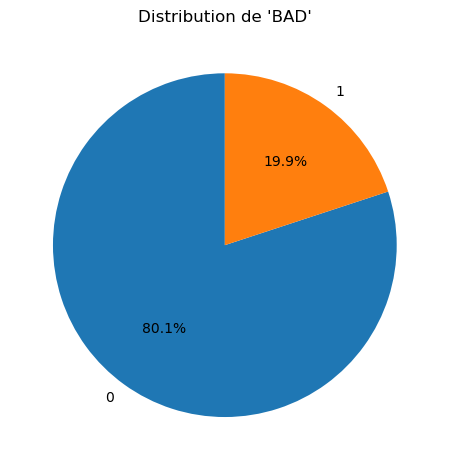

In [9]:
counts = hmeq_data['BAD'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title(f"Distribution de 'BAD'")

plt.tight_layout()
plt.show()

- 20% de BAD et 80% de non bad
- Si pre-processing par la suite, ne pas supprimer les lignes contenant BAD
- Pour le model, possiblement faire data augmentation pour augmenter la partie BAD (ou son importance), ou sous évaluer la partie non bad (poids moindre durant le training)

## Variables numériques

### Analyse de la distribution

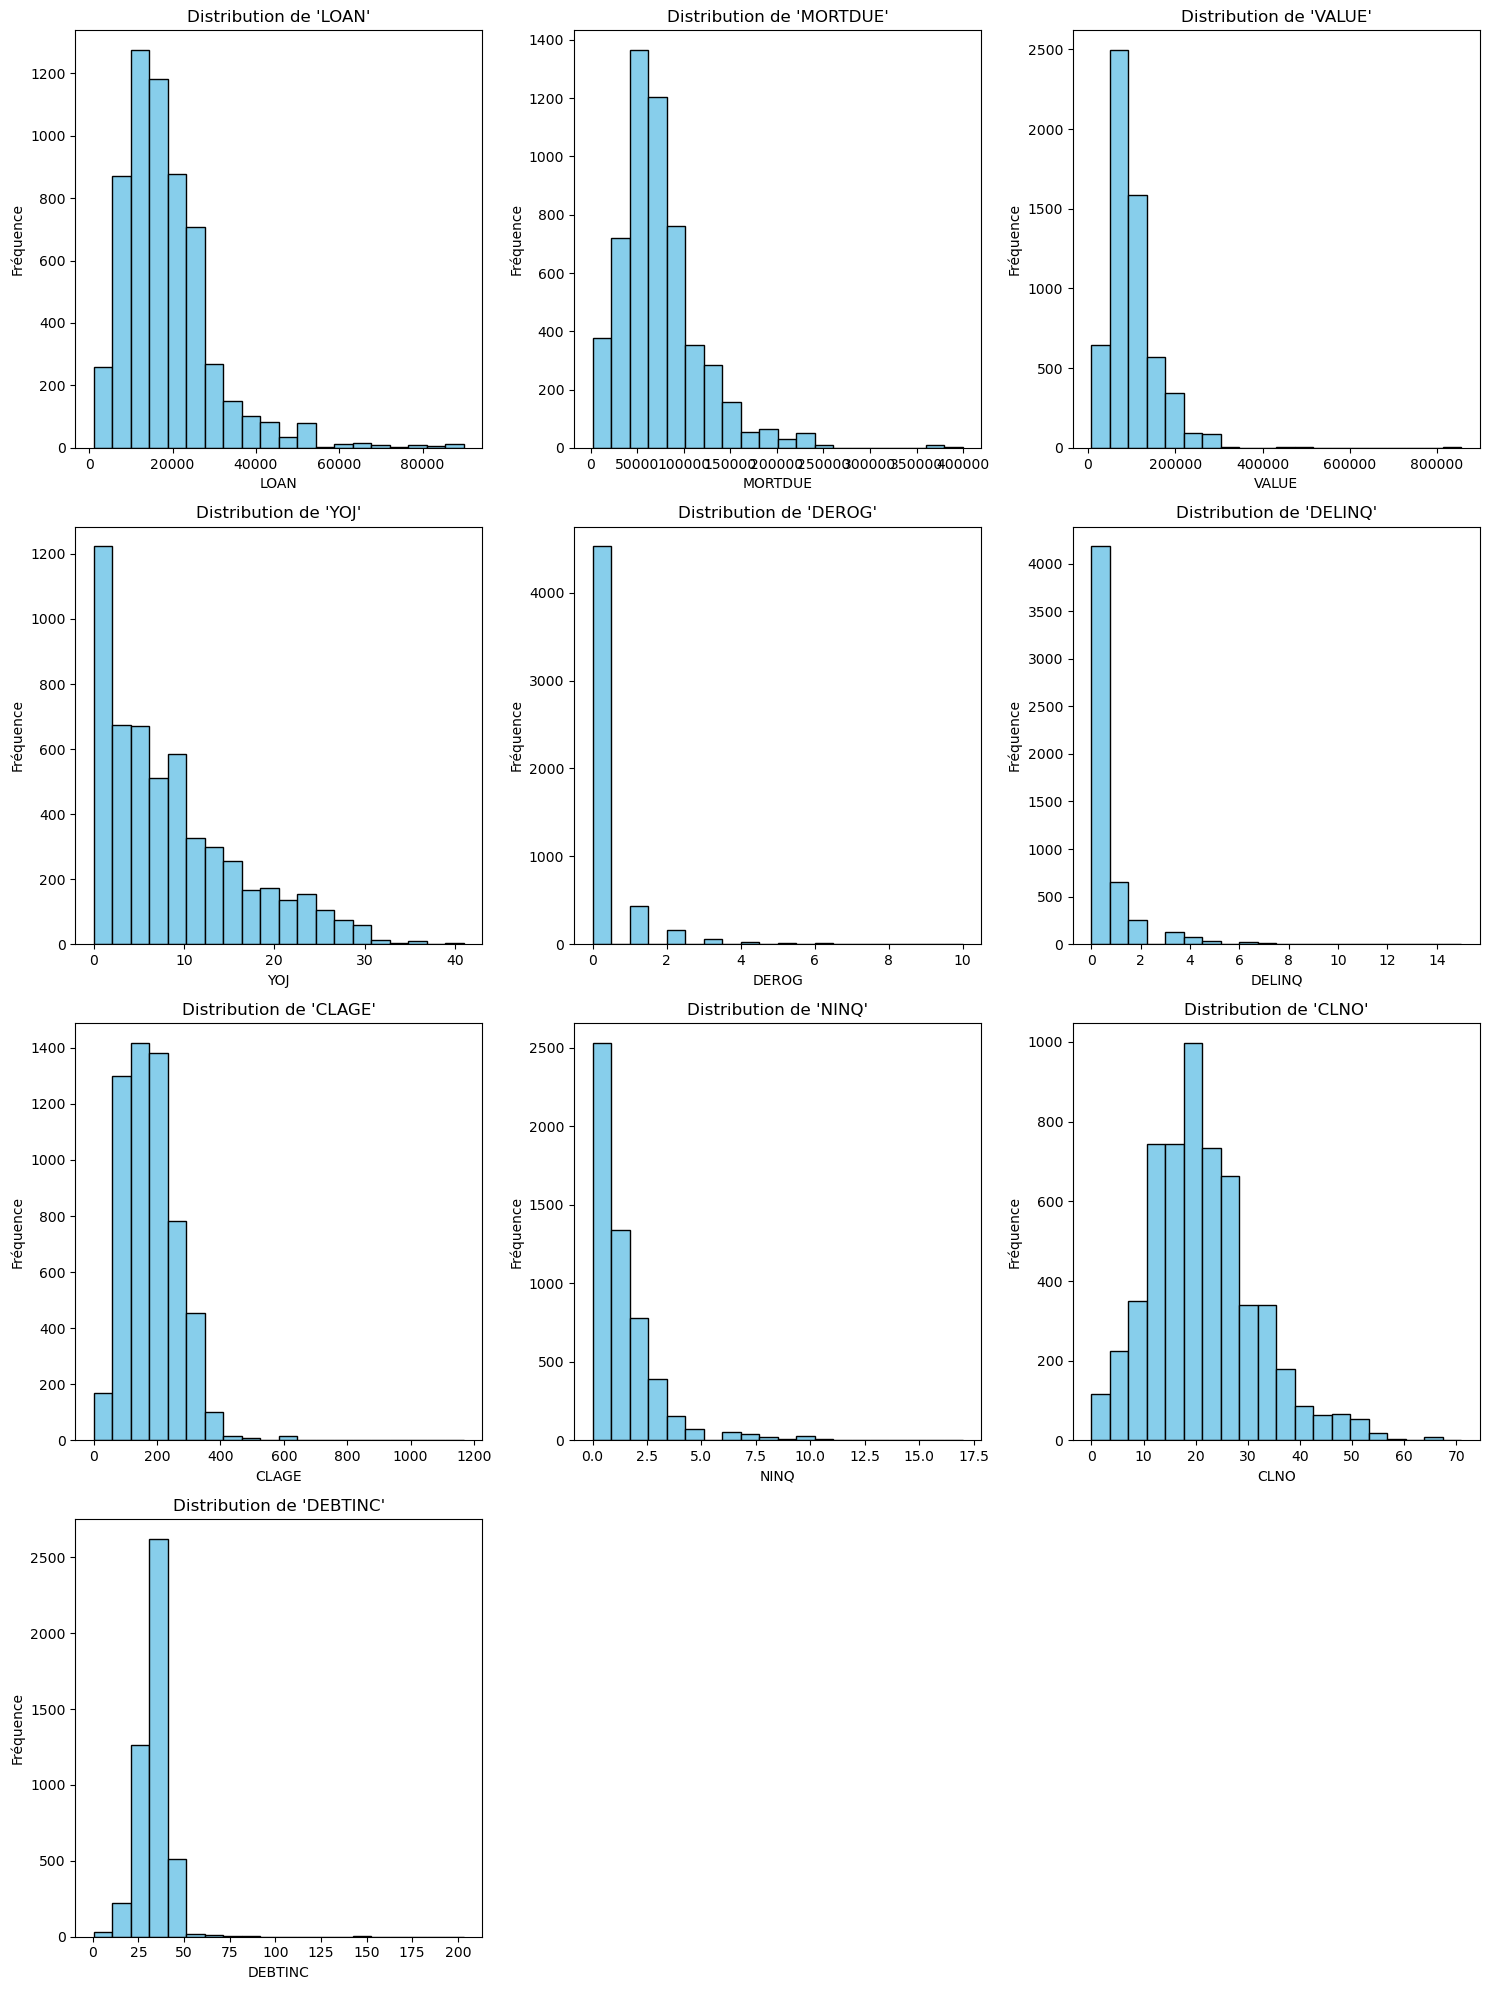

In [10]:
plot_histo(numerical_data.drop(['BAD'], axis=1))

- valeurs extrems ou aberrantes
- que faire ?

### Analyse des outliers

C:\Users\lngeth\AppData\Local\Temp\ipykernel_9460\1610006196.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BAD', y=var, data=df, ax=ax, palette="Set2", flierprops={'markerfacecolor': 'red', 'marker': 'o'})
C:\Users\lngeth\AppData\Local\Temp\ipykernel_9460\1610006196.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BAD', y=var, data=df, ax=ax, palette="Set2", flierprops={'markerfacecolor': 'red', 'marker': 'o'})
C:\Users\lngeth\AppData\Local\Temp\ipykernel_9460\1610006196.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x

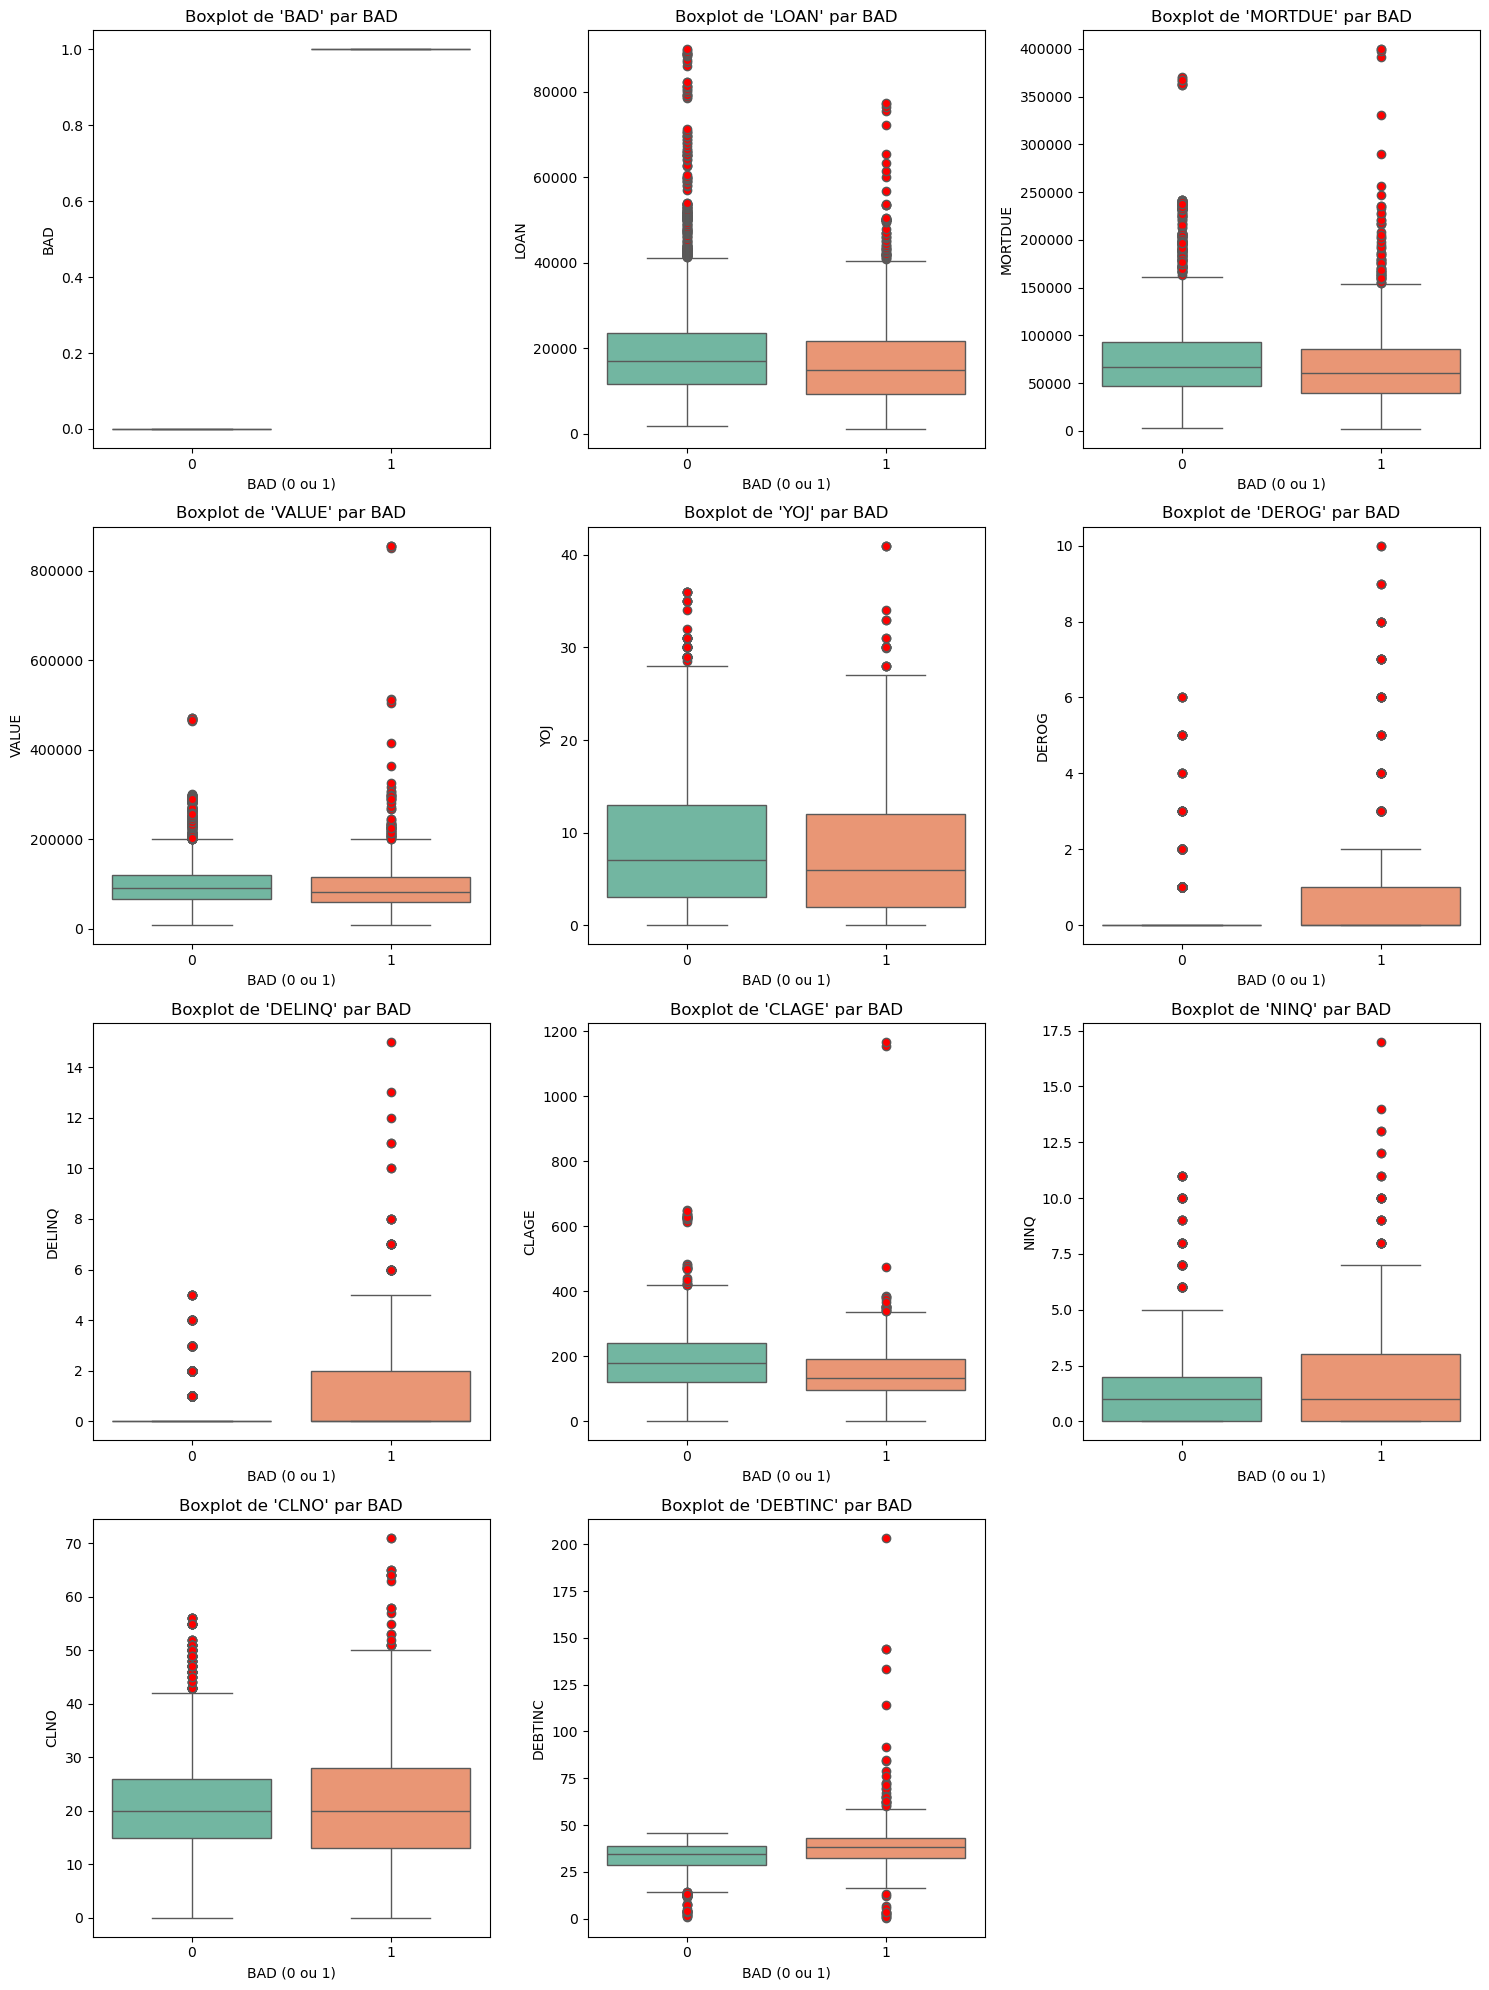

In [11]:
plot_boxplot(numerical_data)

- beaucoup de outliers
- mais outliers plus dans la classe 1 de "BAD" : ceux qui ont fait défaut

### NAN values

In [12]:
#Calculate null values and their percentages for the entire dataset
null_values_df = numerical_data.isnull().sum().reset_index()
null_values_df.columns = ['Column', 'Null_Count']
null_values_df['Overall_Percentage'] = (null_values_df['Null_Count'] / len(numerical_data)) * 100

#Separate data by class
class_0 = numerical_data[numerical_data['BAD'] == 0]
class_1 = numerical_data[numerical_data['BAD'] == 1]

#Calculate null percentages for each class
null_values_class_0 = class_0.isnull().sum().reset_index()
null_values_class_0.columns = ['Column', 'Class_0_Null_Count']
null_values_class_0['Class_0_Percentage'] = (null_values_class_0['Class_0_Null_Count'] / len(class_0)) * 100

null_values_class_1 = class_1.isnull().sum().reset_index()
null_values_class_1.columns = ['Column', 'Class_1_Null_Count']
null_values_class_1['Class_1_Percentage'] = (null_values_class_1['Class_1_Null_Count'] / len(class_1)) * 100

#Merge the results
null_values_df = pd.merge(null_values_df, null_values_class_0[['Column', 'Class_0_Null_Count', 'Class_0_Percentage']], on='Column')
null_values_df = pd.merge(null_values_df, null_values_class_1[['Column', 'Class_1_Null_Count', 'Class_1_Percentage']], on='Column')

#Filter only columns with null values
null_values_df = null_values_df[null_values_df['Null_Count'] > 0]

#Display the result
print(null_values_df)

     Column  Null_Count  Overall_Percentage  Class_0_Null_Count  \
2   MORTDUE         518            8.691275                 412   
3     VALUE         112            1.879195                   7   
4       YOJ         515            8.640940                 450   
5     DEROG         708           11.879195                 621   
6    DELINQ         580            9.731544                 508   
7     CLAGE         308            5.167785                 230   
8      NINQ         510            8.557047                 435   
9      CLNO         222            3.724832                 169   
10  DEBTINC        1267           21.258389                 481   

    Class_0_Percentage  Class_1_Null_Count  Class_1_Percentage  
2             8.635506                 106            8.915055  
3             0.146720                 105            8.830950  
4             9.431985                  65            5.466779  
5            13.016139                  87            7.317073  
6   

- Toutes les variables numériques ont entre 1 et 20% de valeurs manquantes.
- Si supprime ça fait bcp d'infos perdus
  
- De plus, 66% des valeurs null de la variable 'DEBTINC' sont de class_1 donc :

In [13]:
nb_approx_val_BAD_1 = (len(hmeq_data) * 0.2)
print(f"Nb NaN values dans colonne DEBTINC : {nb_approx_val_BAD_1}")
print(f"Nb observation BAD=1 après dropna de la colonne DEBTINC : {nb_approx_val_BAD_1 - null_values_class_1['Class_1_Null_Count'].iloc[-1]}")

Nb NaN values dans colonne DEBTINC : 1192.0
Nb observation BAD=1 après dropna de la colonne DEBTINC : 406.0


- Si on faisait bêtement un dropna(), on perderait bcp d'infos.
- 406 observations seulement...
- DONC pas de suppression, possiblement une imputation

Voyons dabord les variables catégorielles

## Variable catégorielle

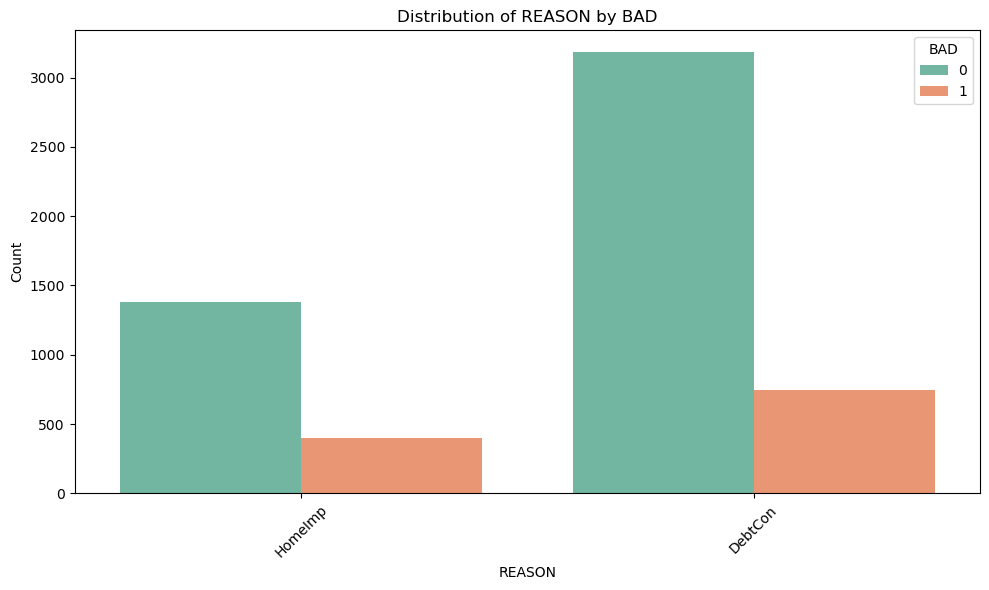

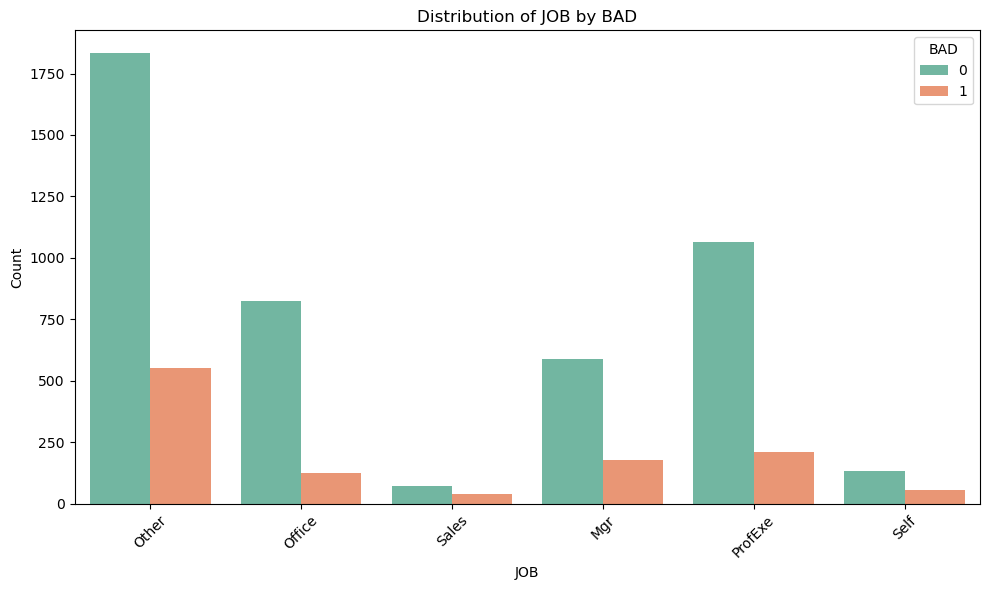

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_distributions(categorical_data, target_column="BAD"):
    """
    Visualizes categorical distributions and highlights outliers using proportions.
    
    Args:
        categorical_data (DataFrame): Data containing categorical features.
        target_column (str): The target variable (e.g., 'BAD').
    """
    for column in categorical_data.columns:
        if column != target_column:
            plt.figure(figsize=(10, 6))
            
            # Plot countplot with hue for the target column
            sns.countplot(data=categorical_data, x=column, hue=target_column, palette="Set2")
            plt.title(f"Distribution of {column} by {target_column}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.legend(title=target_column)
            plt.tight_layout()
            plt.show()

# Call the function to plot categorical data distributions
plot_categorical_distributions(categorical_data)


Nous pouvons clairement voir que certaines catégories sont plus représentées que d'autres. Nous devons en tenir compte lors du traitement des valeurs manquantes.
Ainsi, lorsque nous traitons des valeurs aberrantes, nous devons être prudents lorsque nous abandonnons l'observation avec la raison DebtCon.

### NaN Values

In [15]:
#Initialize a dictionary to store the results
nan_analysis = []

#Loop through each variable
for col in ['REASON', 'JOB']:
    # Total NaN count and percentage for the column
    total_nan = hmeq_data[col].isnull().sum()
    total_nan_percentage = (total_nan / len(hmeq_data)) * 100

    # Count the total rows for each category
    category_counts = hmeq_data[col].value_counts(dropna=False)

    # Loop through categories (including NaN as a category)
    for category, total_count in category_counts.items():
        # Count rows where the value is NaN for this category
        nan_count = hmeq_data[(hmeq_data[col] == category) & (hmeq_data[col].isnull())].shape[0]

        # Calculate the percentage of NaNs for this category
        category_nan_percentage = (nan_count / total_count) * 100 if total_count > 0 else 0

        # Append results
        nan_analysis.append({
            'Variable': col,
            'Category': category if pd.notnull(category) else 'NaN',
            'Total_NaN_Percentage': total_nan_percentage,
            'Category_NaN_Percentage': category_nan_percentage
        })

#Convert results to a DataFrame
nan_analysis_df = pd.DataFrame(nan_analysis)

#Display the result
print(nan_analysis_df)

  Variable Category  Total_NaN_Percentage  Category_NaN_Percentage
0   REASON  DebtCon              4.228188                      0.0
1   REASON  HomeImp              4.228188                      0.0
2   REASON      NaN              4.228188                      0.0
3      JOB    Other              4.681208                      0.0
4      JOB  ProfExe              4.681208                      0.0
5      JOB   Office              4.681208                      0.0
6      JOB      Mgr              4.681208                      0.0
7      JOB      NaN              4.681208                      0.0
8      JOB     Self              4.681208                      0.0
9      JOB    Sales              4.681208                      0.0


- Observations

# Outliers treatment

Compte tenu des informations vu précémment :
- Bcp plus de BAD=0 que de BAD=1 (80% contre 20%)
- Outliers présents en grande majorité dans la classe 1 de BAD
- BCP de NaN values notemmant dans DEBTINC (700) mais 66% sont dans class 1 de BAD

DONC on les garde

# NaN Values Treatment

Nous avons vu q'il yavat :
- bcp de NaN values, il faut les supprimer ou les traiter
- d'une part pour les variables numériques et catégroielles

## NaN in numerical data

On choisit de visualier les imputations (MEAN, MEDIAN, KNN)

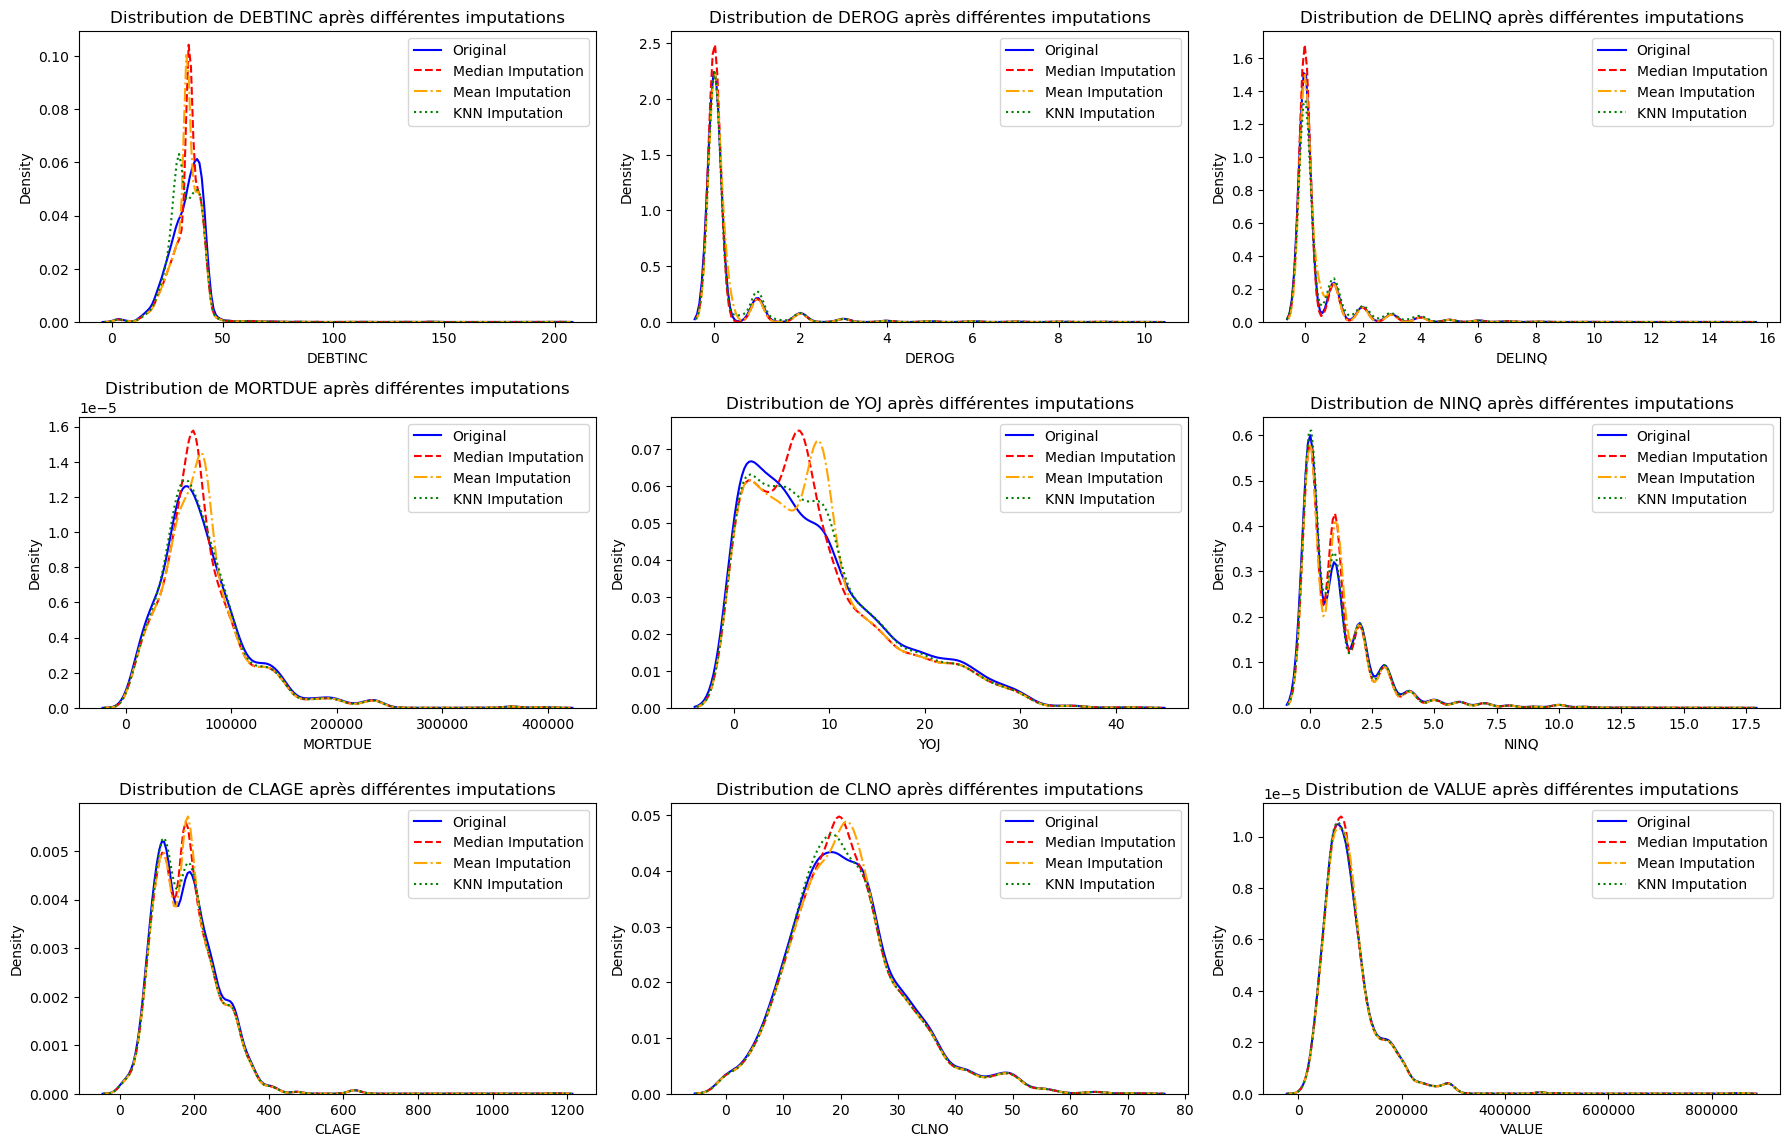

In [16]:
hmeq_data_original = hmeq_data.copy()

# Imputer les données manquantes numériques par la médiane
imputer_numeric = SimpleImputer(strategy='median')
hmeq_data_median_filled = hmeq_data_original.copy()  # Nouvelle base pour la médiane
hmeq_data_median_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']] = imputer_numeric.fit_transform(
    hmeq_data_median_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']]
)


# Imputation par la moyenne
imputer_mean = SimpleImputer(strategy='mean')
hmeq_data_mean_filled = hmeq_data_original.copy()  # Nouvelle base pour la moyenne
hmeq_data_mean_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']] = imputer_mean.fit_transform(
    hmeq_data_mean_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']]
)

# Imputation par KNN
imputer_knn = KNNImputer(n_neighbors=5)
hmeq_data_knn_filled = hmeq_data_original.copy()  # Nouvelle base pour KNN
hmeq_data_knn_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']] = imputer_knn.fit_transform(
    hmeq_data_knn_filled[['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE']]
)

plt.figure(figsize=(18, 15))
for i, col in enumerate(['DEBTINC', 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ', 'NINQ', 'CLAGE', 'CLNO', 'VALUE'], 1):
    plt.subplot(4, 3, i)
    sns.kdeplot(hmeq_data_original[col].dropna(), label='Original', color='blue', linestyle='-')
    sns.kdeplot(hmeq_data_median_filled[col], label='Median Imputation', color='red', linestyle='--')
    sns.kdeplot(hmeq_data_mean_filled[col], label='Mean Imputation', color='orange', linestyle='-.')
    sns.kdeplot(hmeq_data_knn_filled[col], label='KNN Imputation', color='green', linestyle=':')
    plt.title(f'Distribution de {col} après différentes imputations')
    plt.legend()

plt.tight_layout()
plt.show()

- Lequel est mieux?

Le graphique compare les méthodes d’imputation : médiane, moyenne et KNN. L’imputation par médiane est robuste aux outliers et conserve les distributions asymétriques (DEBTINC, DEROG), mais simplifie les données et lisse les distributions (CLAGE, YOJ).  
La moyenne, sensible aux outliers, déforme les distributions (MORTDUE, DEBTINC) et réduit la variabilité. KNN, en revanche, préserve mieux les distributions originales (YOJ, CLAGE, NINQ) en tenant compte des relations entre variables, mais est plus coûteux en calculs.

La méthode KNN est recommandée pour préserver la variabilité et les relations, avec l’imputation par médiane comme alternative en cas de fortes contraintes. La moyenne est la moins adaptée.

In [17]:
# Verify the results
print("Missing values after imputation:")
print(hmeq_data_knn_filled.isnull().sum())

Missing values after imputation:
BAD          0
LOAN         0
MORTDUE      0
VALUE        0
REASON     252
JOB        279
YOJ          0
DEROG        0
DELINQ       0
CLAGE        0
NINQ         0
CLNO         0
DEBTINC      0
dtype: int64


In [18]:
hmeq_data_knn_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5960 non-null   float64
 3   VALUE    5960 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  5960 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


## NaN in catégorial data

Notre objectif :
- Combler les NaN values dans les variables catégorielles
- on va remplacer par le MOD
- On va voir la distribution avant (avec les nan values)
- Ensuite plot la distribution après remplacement par le MOD (NaN ont été comblés -> les autres classes ont augmentés)

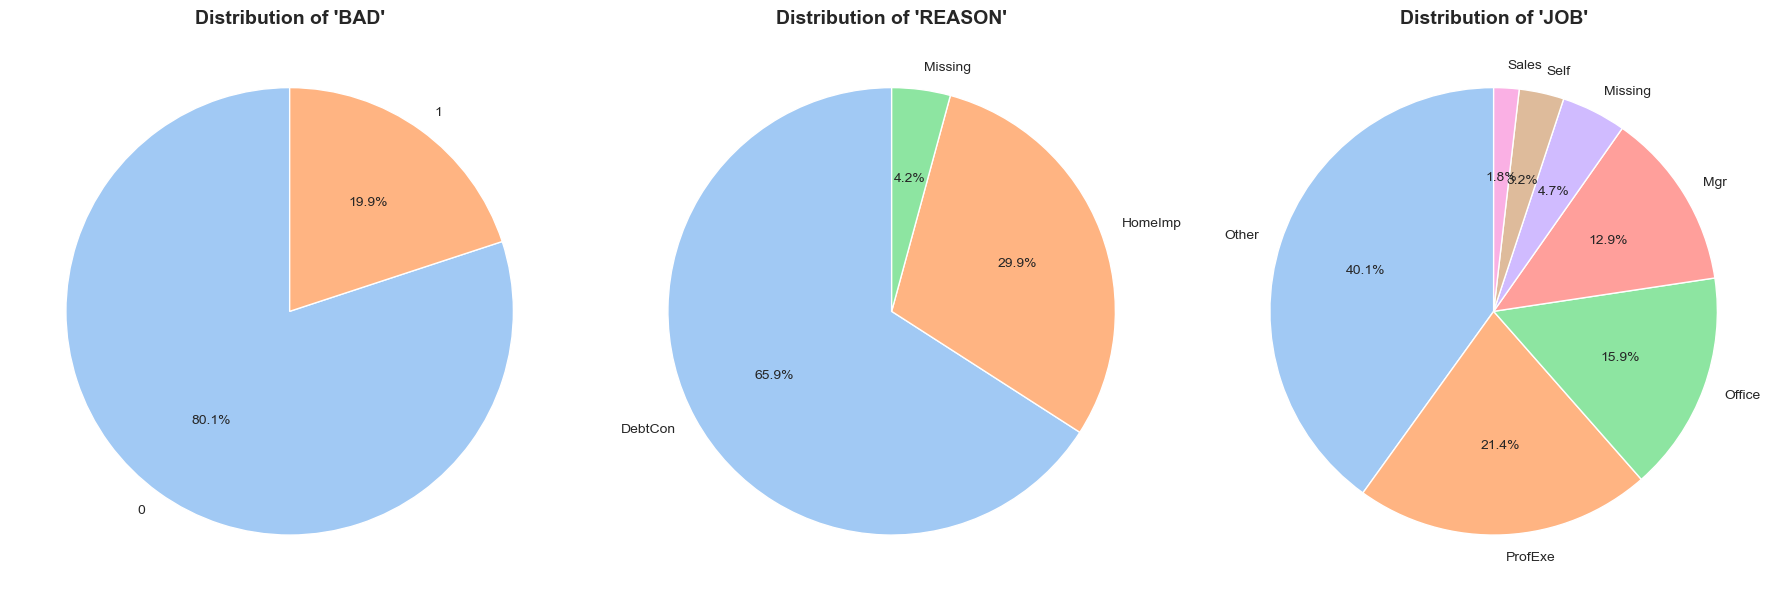

In [19]:
def plot_categorical_pie_charts_seaborn(data, categorical_vars, nan_class_label="Missing"):
    """
    Creates aesthetically pleasing pie charts for categorical variables using Seaborn styling,
    including NaNs as a separate class.

    Args:
        data (pd.DataFrame): The dataset containing categorical variables.
        categorical_vars (list): List of categorical variable names.
        nan_class_label (str): Label to use for missing values in the pie chart.
    """
    sns.set_theme(style="whitegrid")  # Set Seaborn theme
    num_vars = len(categorical_vars)
    fig, axes = plt.subplots(1, num_vars, figsize=(6 * num_vars, 6), subplot_kw={'aspect': 'equal'})

    # Ensure axes is iterable for a single plot case
    axes = axes.flatten() if num_vars > 1 else [axes]

    for i, var in enumerate(categorical_vars):
        # Include NaNs as a separate class
        counts = data[var].value_counts(dropna=False)
        labels = counts.index.to_list()
        labels = [str(label) if pd.notna(label) else nan_class_label for label in labels]

#Seaborn color palette
        colors = sns.color_palette("pastel", len(labels))

#Create pie chart
        wedges, texts, autotexts = axes[i].pie(
            counts,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            textprops={'fontsize': 10}
        )

#Add a title
        axes[i].set_title(f"Distribution of '{var}'", fontsize=14, fontweight='bold')

#Adjust layout for better visuals
    plt.tight_layout()
    plt.show()

#Define categorical variables
categorical_vars = ['BAD', 'REASON', 'JOB']

#Call the function
plot_categorical_pie_charts_seaborn(hmeq_data, categorical_vars)

In [56]:
# Copy the original data
hmeq_data_processed = hmeq_data_knn_filled.copy()

# Impute missing values for categorical columns using mode
mode_imputer = SimpleImputer(strategy='most_frequent')
hmeq_data_processed[categorical_cols] = mode_imputer.fit_transform(hmeq_data_processed[categorical_cols])

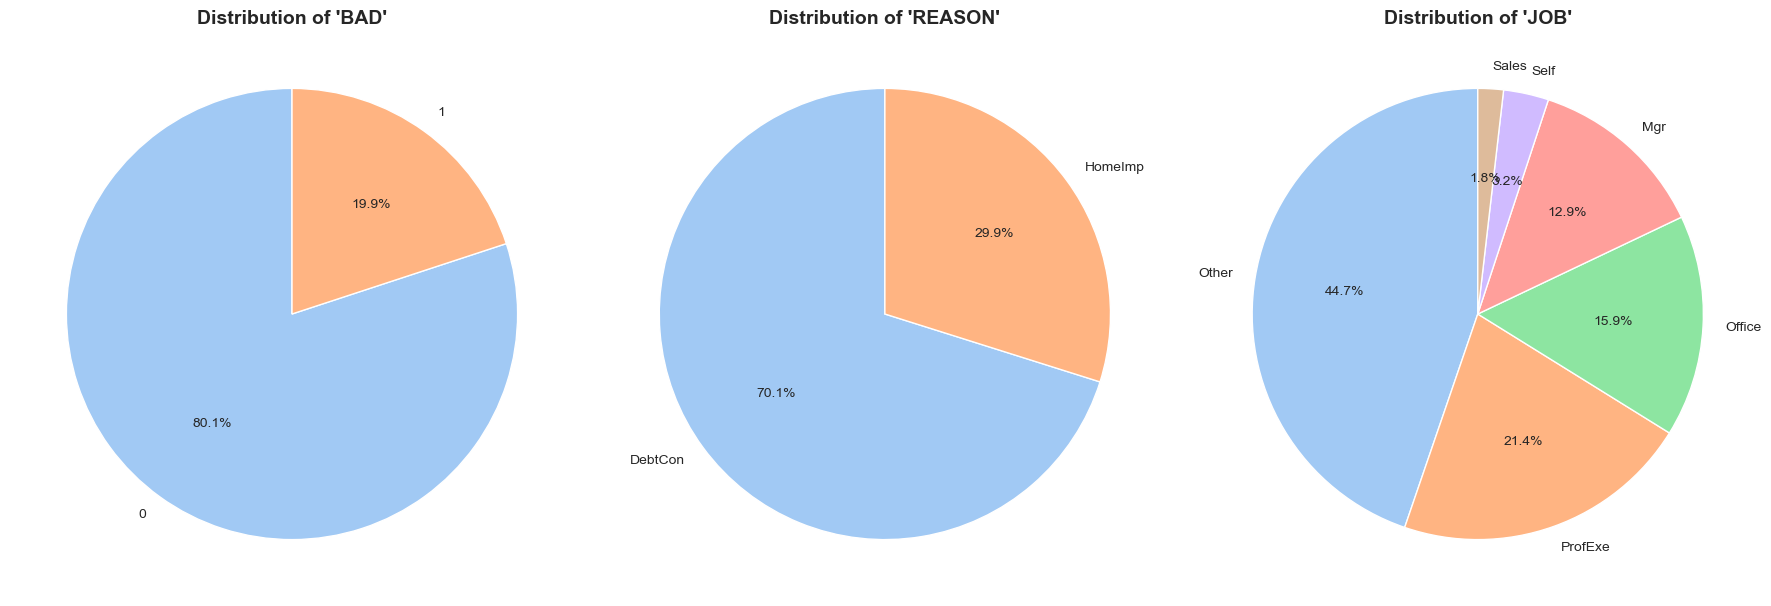

In [57]:
plot_categorical_pie_charts_seaborn(hmeq_data_processed, categorical_vars)

In [58]:
# Verify the results
print("Missing values after imputation:")
print(hmeq_data_processed.isnull().sum())

Missing values after imputation:
BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64


Nous avons traité toutes les valeurs manquantes, que ce soit pour les variables numériques ou les valeurs catégorielles.

# Features selection

La corrélation nécessite des données complètes :

Une matrice de corrélation ne peut pas traiter les valeurs NaN car les valeurs manquantes entraînent des relations non définies entre les variables.
Impact sur les relations entre les variables :

Les données manquantes peuvent fausser la matrice de corrélation, en particulier si les données manquantes ne sont pas aléatoires ou si elles sont présentes dans des caractéristiques critiques.  
C'est pourquoi nous avons traité dabord les NaN/missings values.

In [59]:
def plot_corr_matrix(df, cols):
  # Calcul de la matrice de corrélation avec la méthode Spearman
  spearman_corr_matrix = df[cols].corr(method='spearman')

  # Afficher la matrice de corrélation sous forme de heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(spearman_corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
  plt.title('Matrice de corrélation (Spearman)')
  plt.show()

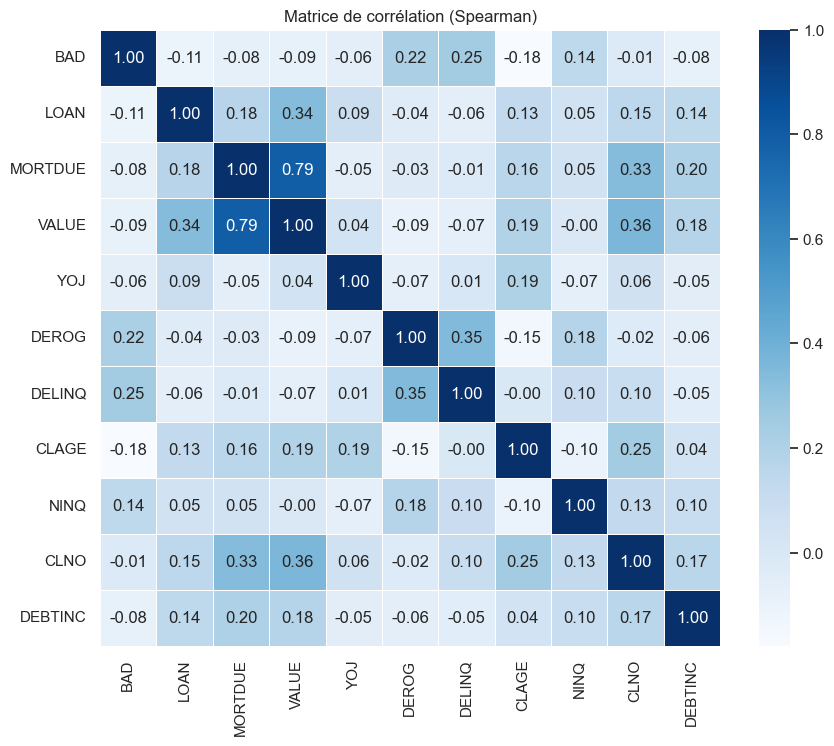

In [60]:
plot_corr_matrix(hmeq_data_processed, numerical_cols)

Forte corrélation entre les variables :

MORTDUE et VALEUR : forte corrélation positive (~0,79), suggérant une possible multicolinéarité.
CLNO et VALUE : corrélation modérée (~0,36).
CLNO et MORTDUE : corrélation modérée (~0,33).
Faible corrélation avec la cible (BAD) :

La plupart des caractéristiques ont une faible corrélation avec BAD, ce qui implique qu'elles n'influencent pas fortement la cible directement.

Mais la matrice de corrélation ne représente que les relations linéaires entre les variables. Peut être qu'il existe des relations plus complexes que nous ne percevons pas ?  
Voyons, avec le VIF pour confirmer :

In [61]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF for numerical features
vif = calculate_vif(hmeq_data_processed[numerical_cols].drop(['BAD'], axis=1))
print(vif)

   Feature        VIF
0     LOAN   4.228522
1  MORTDUE  10.686841
2    VALUE  11.628782
3      YOJ   2.610895
4    DEROG   1.206690
5   DELINQ   1.322557
6    CLAGE   5.758376
7     NINQ   1.554082
8     CLNO   6.658490
9  DEBTINC   8.736695


Le VIF nous confirme que MORTDUE et VALUE ont une value élevé.  
Au niveau de leur corrélation avec BAD, c'est équivalent (cor(MORTDUE, BAD) = cor(VALUE, BAD)).  
On choisit de supprimer VALUE qui a le VIF le plus élevé.

In [62]:
hmeq_data_processed_features_selected = hmeq_data_processed.drop(['VALUE'], axis=1)
hmeq_data_processed_features_selected.head()

,BAD,LOAN,MORTDUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0000,HomeImp,Other,10.500000,0.00000,0.000000,94.366667,1.000000,9.000000,27.351325
1,1,1300,70053.0000,HomeImp,Other,7.000000,0.00000,2.000000,121.833333,0.000000,14.000000,29.764339
2,1,1500,13500.0000,HomeImp,Other,4.000000,0.00000,0.000000,149.466667,1.000000,10.000000,28.138068
3,1,1500,73760.8172,DebtCon,Other,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,0,1700,97800.0000,HomeImp,Office,3.000000,0.00000,0.000000,93.333333,0.000000,14.000000,30.898685


Réitérons ce process.

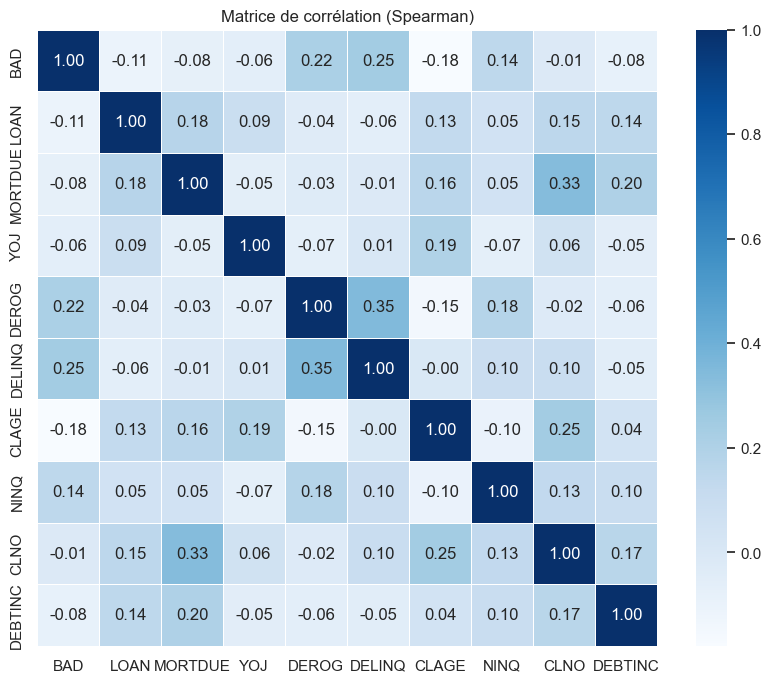

In [63]:
tmp_cols = numerical_cols.copy()
tmp_cols.remove('VALUE')
plot_corr_matrix(hmeq_data_processed_features_selected, tmp_cols)

In [64]:
print(calculate_vif(hmeq_data_processed_features_selected[tmp_cols].drop(['BAD'], axis=1)))

   Feature       VIF
0     LOAN  3.945483
1  MORTDUE  4.637853
2      YOJ  2.582996
3    DEROG  1.206646
4   DELINQ  1.319773
5    CLAGE  5.739043
6     NINQ  1.550543
7     CLNO  6.653986
8  DEBTINC  8.718474


Corrélation avec d'autres caractéristiques financières :  
Des variables telles que LOAN, MORTDUE ou CLNO peuvent affecter indirectement DEBTINC.  
  
Par exemple :  
PRÊT : Des prêts plus importants augmentent généralement la dette totale, ce qui influence le ratio dette/revenu.  
MORTDUE : L'encours des prêts hypothécaires contribue de manière significative à l'endettement total.  
CLNO (Nombre de lignes de crédit) : Un nombre plus élevé de lignes de crédit peut indiquer un endettement plus important, ce qui a un impact sur le rapport dette/revenu.  
  
Il est donc possible de supprimer DEBTINC

In [65]:
hmeq_data_processed_features_selected = hmeq_data_processed_features_selected.drop(['DEBTINC'], axis=1)
hmeq_data_processed_features_selected.head()

,BAD,LOAN,MORTDUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
0,1,1100,25860.0000,HomeImp,Other,10.500000,0.00000,0.000000,94.366667,1.000000,9.000000
1,1,1300,70053.0000,HomeImp,Other,7.000000,0.00000,2.000000,121.833333,0.000000,14.000000
2,1,1500,13500.0000,HomeImp,Other,4.000000,0.00000,0.000000,149.466667,1.000000,10.000000
3,1,1500,73760.8172,DebtCon,Other,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096
4,0,1700,97800.0000,HomeImp,Office,3.000000,0.00000,0.000000,93.333333,0.000000,14.000000


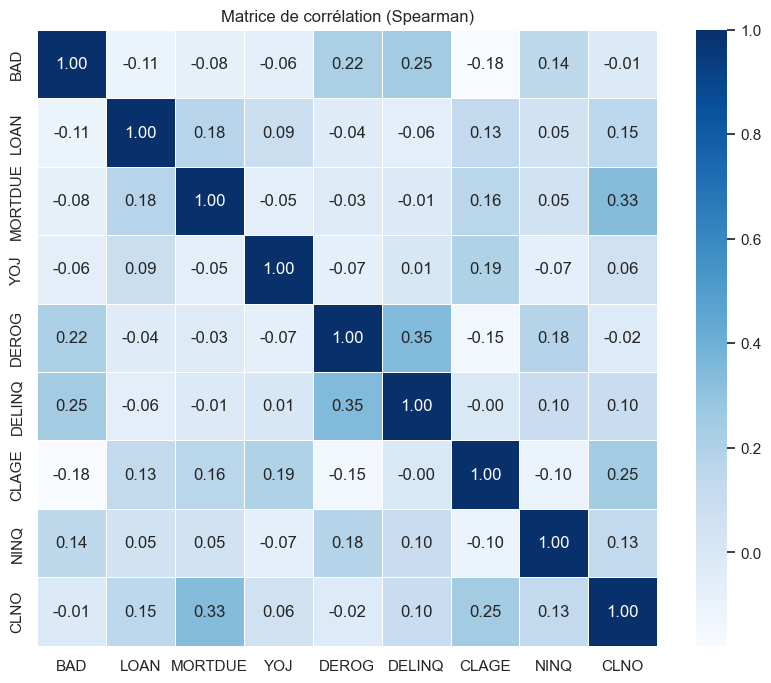

In [67]:
tmp_cols = numerical_cols.copy()
tmp_cols.remove('DEBTINC')
tmp_cols.remove('VALUE')
plot_corr_matrix(hmeq_data_processed_features_selected, tmp_cols)

In [68]:
print(calculate_vif(hmeq_data_processed_features_selected[tmp_cols].drop(['BAD'], axis=1)))

   Feature       VIF
0     LOAN  3.639965
1  MORTDUE  4.366687
2      YOJ  2.511928
3    DEROG  1.200803
4   DELINQ  1.319773
5    CLAGE  5.287218
6     NINQ  1.502161
7     CLNO  5.928165


L'indicateur VIF pour le CLAGE et le CLNO est supérieur à 5, ce qui peut s'expliquer logiquement compte tenu de la nature des deux variables. Nous décidons de conserver CLAGE et d'abandonner CLNO car la première est plus corrélée à la caractéristique cible.  
- MAIS comme CLNO est moins corrélé avec BAD, on va supprimer CLNO

In [69]:
hmeq_data_processed_features_selected = hmeq_data_processed_features_selected.drop(['CLNO'], axis=1)
hmeq_data_processed_features_selected.head()

,BAD,LOAN,MORTDUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ
0,1,1100,25860.0000,HomeImp,Other,10.500000,0.00000,0.000000,94.366667,1.000000
1,1,1300,70053.0000,HomeImp,Other,7.000000,0.00000,2.000000,121.833333,0.000000
2,1,1500,13500.0000,HomeImp,Other,4.000000,0.00000,0.000000,149.466667,1.000000
3,1,1500,73760.8172,DebtCon,Other,8.922268,0.25457,0.449442,179.766275,1.186055
4,0,1700,97800.0000,HomeImp,Office,3.000000,0.00000,0.000000,93.333333,0.000000


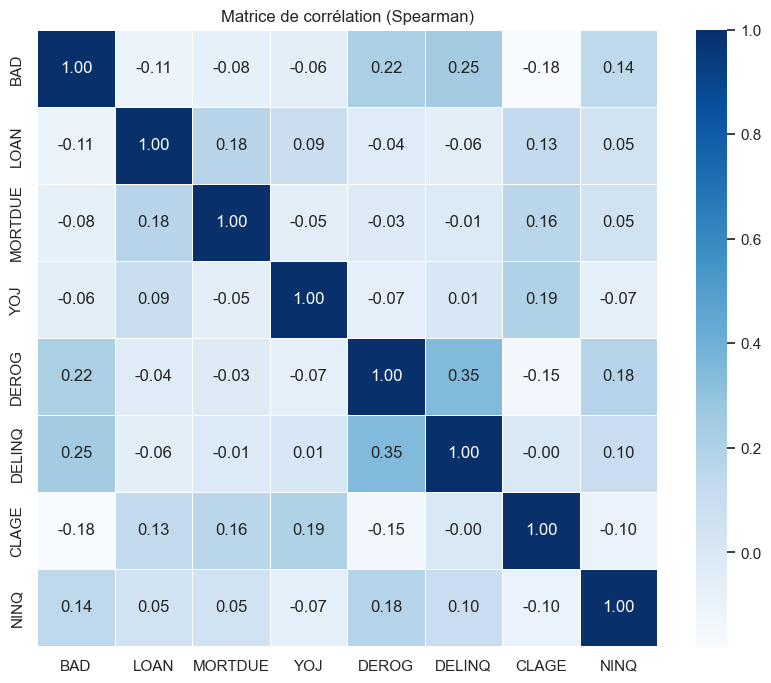

In [70]:
tmp_cols = numerical_cols.copy()
tmp_cols.remove('DEBTINC')
tmp_cols.remove('VALUE')
tmp_cols.remove('CLNO')
plot_corr_matrix(hmeq_data_processed_features_selected, tmp_cols)

In [71]:
print(calculate_vif(hmeq_data_processed_features_selected[tmp_cols].drop(['BAD'], axis=1)))

   Feature       VIF
0     LOAN  3.597485
1  MORTDUE  3.638058
2      YOJ  2.473907
3    DEROG  1.194384
4   DELINQ  1.284923
5    CLAGE  4.466652
6     NINQ  1.462597


La matrice de corr est ok et le VIF OK (- de 5). DONC C'est bon.

In [79]:
numerical_cols = tmp_cols
numerical_cols.remove('BAD')

# Models

## Data prep

In [29]:
# numerical_data_treated
# categorical_data_treated

In [81]:
hmeq_data_processed_features_selected_label_encoded[numerical_cols]

,LOAN,MORTDUE,YOJ,DEROG,DELINQ,CLAGE,NINQ
0,1100,25860.0000,10.500000,0.00000,0.000000,94.366667,1.000000
1,1300,70053.0000,7.000000,0.00000,2.000000,121.833333,0.000000
2,1500,13500.0000,4.000000,0.00000,0.000000,149.466667,1.000000
3,1500,73760.8172,8.922268,0.25457,0.449442,179.766275,1.186055
4,1700,97800.0000,3.000000,0.00000,0.000000,93.333333,0.000000
...,...,...,...,...,...,...,...
5955,88900,57264.0000,16.000000,0.00000,0.000000,221.808718,0.000000
5956,89000,54576.0000,16.000000,0.00000,0.000000,208.692070,0.000000
5957,89200,54045.0000,15.000000,0.00000,0.000000,212.279697,0.000000
5958,89800,50370.0000,14.000000,0.00000,0.000000,213.892709,0.000000


Encodons les variables catégorielles :

In [80]:
label_encoder = LabelEncoder()

# Apply Label Encoding to each categorical column
hmeq_data_processed_features_selected_label_encoded = hmeq_data_processed_features_selected.copy()
for col in categorical_cols:
    hmeq_data_processed_features_selected_label_encoded[col] = label_encoder.fit_transform(hmeq_data_processed_features_selected_label_encoded[col])

print("Data after Label Encoding:")
print(hmeq_data_processed_features_selected_label_encoded.head())

Data after Label Encoding:
   BAD  LOAN     MORTDUE  REASON  JOB        YOJ    DEROG    DELINQ  \
0    1  1100  25860.0000       1    2  10.500000  0.00000  0.000000   
1    1  1300  70053.0000       1    2   7.000000  0.00000  2.000000   
2    1  1500  13500.0000       1    2   4.000000  0.00000  0.000000   
3    1  1500  73760.8172       0    2   8.922268  0.25457  0.449442   
4    0  1700  97800.0000       1    1   3.000000  0.00000  0.000000   

        CLAGE      NINQ  
0   94.366667  1.000000  
1  121.833333  0.000000  
2  149.466667  1.000000  
3  179.766275  1.186055  
4   93.333333  0.000000  


Séparons

In [83]:
# Define features (X) and target (y)
X = hmeq_data_processed_features_selected_label_encoded.drop(columns=['BAD'])  # Drop the target column
y = hmeq_data_processed_features_selected_label_encoded['BAD']  # Target column

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the shapes of the splits
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Target Shape: {y_test.shape}")

Training Features Shape: (4768, 9)
Testing Features Shape: (1192, 9)
Training Target Shape: (4768,)
Testing Target Shape: (1192,)


## Fonction train_and_test_model

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

def train_and_test_model(
    X_train,
    y_train,
    X_test,
    y_test,
    model,
    param_grid,
    model_name="Model",
    scoring='roc_auc',
    search_type='grid',
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=1,
    plot=True
):
    # Split train/validation
    X_train_new, X_val, y_train_new, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train
    )
    print(f"Training set size: {X_train_new.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")

    # Search type (GridSearchCV or RandomizedSearchCV)
    if search_type == 'grid':
        search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose
        )
    else:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring=scoring,
            cv=cv,
            random_state=42,
            n_jobs=n_jobs,
            verbose=verbose
        )

    # Fit the search
    search.fit(X_train_new, y_train_new)
    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    print(f"{model_name} - Best Parameters: {best_params}")
    print(f"{model_name} - Best {scoring}: {best_score:.3f}")

    # Retrain on full training set
    best_model.fit(X_train, y_train)

    # Predictions
    y_proba_train = best_model.predict_proba(X_train)[:, 1]
    y_proba_test = best_model.predict_proba(X_test)[:, 1]
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Metrics
    train_auc = roc_auc_score(y_train, y_proba_train)
    test_auc = roc_auc_score(y_test, y_proba_test)
    train_bal_acc = balanced_accuracy_score(y_train, y_pred_train)
    test_bal_acc = balanced_accuracy_score(y_test, y_pred_test)

    print(f"\n{model_name} - Training ROC-AUC: {train_auc:.3f}")
    print(f"{model_name} - Training Balanced Accuracy: {train_bal_acc:.3f}")
    print(f"{model_name} - Test ROC-AUC: {test_auc:.3f}")
    print(f"{model_name} - Test Balanced Accuracy: {test_bal_acc:.3f}")

    # Plot ROC Curve
    if plot:
        fpr, tpr, _ = roc_curve(y_test, y_proba_test)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {test_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label="Baseline")
        plt.title(f'ROC Curve - {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()
        plt.show()

    return best_model, best_params, {
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_bal_acc': train_bal_acc,
        'test_bal_acc': test_bal_acc
    }


#  modèle de forêt aléatoire

Training set size: 3814
Validation set size: 954
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Random Forest - Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Best roc_auc: 0.936

Random Forest - Training ROC-AUC: 1.000
Random Forest - Training Balanced Accuracy: 1.000
Random Forest - Test ROC-AUC: 0.950
Random Forest - Test Balanced Accuracy: 0.777


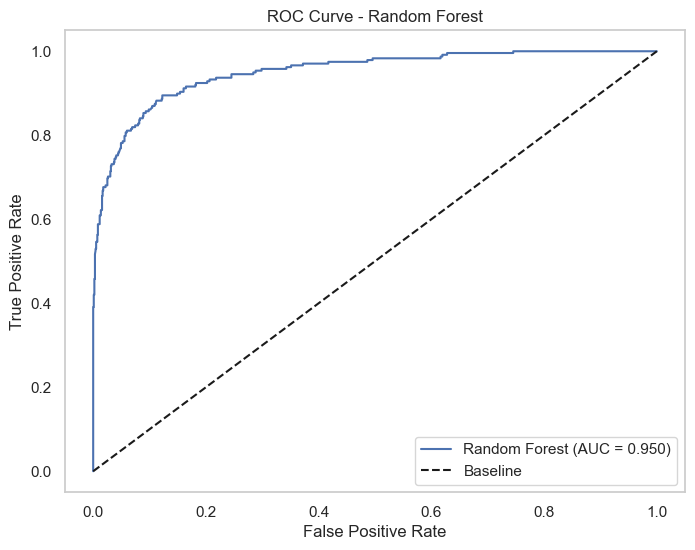

In [85]:
# Définir le modèle
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Définir la grille d'hyperparamètres
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Nombre d'arbres
    'max_depth': [5, 10, 20],       # Profondeur maximale
    'min_samples_split': [2, 5, 10], # Min. échantillons pour division
    'min_samples_leaf': [1, 2, 4],   # Min. échantillons dans une feuille
    'bootstrap': [True, False]       # Échantillonnage bootstrap
}

# Appeler la fonction
best_rf, best_params_rf, metrics_rf = train_and_test_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model=rf_clf,
    param_grid=param_grid_rf,
    model_name="Random Forest",
    scoring='roc_auc',
    search_type='grid',  # Changer en 'random' pour RandomizedSearchCV
    cv=5,
    n_iter=200,          # Utilisé uniquement pour RandomizedSearchCV
    n_jobs=-1,
    verbose=2,
    plot=True
)


# Régression Logistique

Training set size: 3814
Validation set size: 954
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Régression Logistique - Best Parameters: {'C': 1, 'penalty': 'l1'}
Régression Logistique - Best roc_auc: 0.766

Régression Logistique - Training ROC-AUC: 0.766
Régression Logistique - Training Balanced Accuracy: 0.697
Régression Logistique - Test ROC-AUC: 0.719
Régression Logistique - Test Balanced Accuracy: 0.676


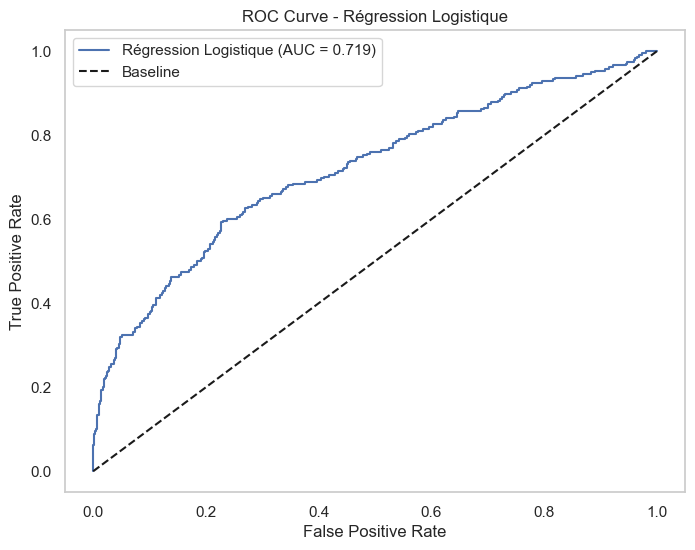

In [86]:
from sklearn.linear_model import LogisticRegression

# Définir le modèle
log_clf = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

# Définir la grille d'hyperparamètres
param_grid_log = {
    'C': [0.01, 0.1, 1, 10],        # Paramètre de régularisation
    'penalty': ['l1', 'l2']         # Type de régularisation
}

# Appeler la fonction
best_log, best_params_log, metrics_log = train_and_test_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model=log_clf,
    param_grid=param_grid_log,
    model_name="Régression Logistique",
    scoring='roc_auc',
    search_type='grid',  # Changer en 'random' pour RandomizedSearchCV
    cv=5,
    n_iter=100,
    n_jobs=-1,
    verbose=2,
    plot=True
)


# Gradient Boosting (XGBoost)

In [93]:
class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y, **fit_params):
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

    def get_params(self, deep=True):
        return self.model.get_params(deep=deep)
      
# Initialize the wrapped XGBClassifier
xgb = SklearnXGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

Training set size: 3814
Validation set size: 954
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


d:\Development\anaconda3\envs\brain-anatomy-schizophrenia\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan

XGBoost - Best Parameters: {'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 20}
XGBoost - Best roc_auc: nan

XGBoost - Training ROC-AUC: 0.740
XGBoost - Training Balanced Accuracy: 0.500
XGBoost - Test ROC-AUC: 0.708
XGBoost - Test Balanced Accuracy: 0.500


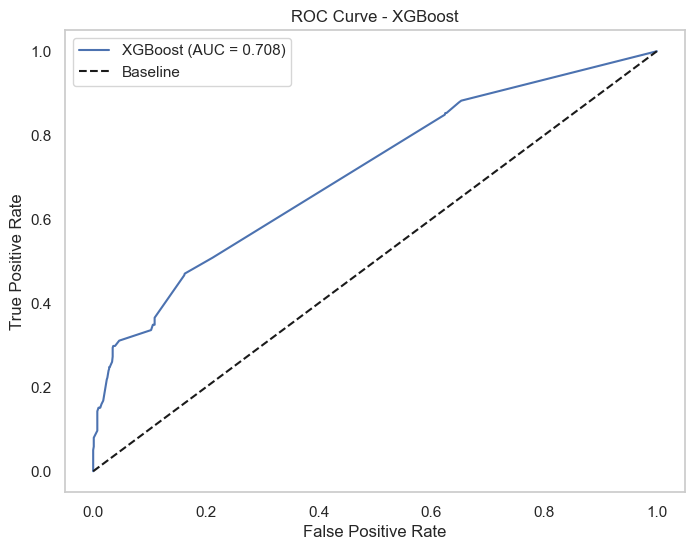

In [94]:
from xgboost import XGBClassifier

# Définir le modèle
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Définir la grille d'hyperparamètres
# param_grid_xgb = {
#     'n_estimators': [50, 100, 200],     # Nombre d'arbres
#     'learning_rate': [0.01, 0.1, 0.2],  # Taux d'apprentissage
#     'max_depth': [3, 5, 10],            # Profondeur maximale
#     'subsample': [0.8, 1.0],            # Fraction des échantillons utilisés
#     'colsample_bytree': [0.8, 1.0]      # Fraction des colonnes utilisées
# }

param_dist_xgb = {
    'n_estimators': [20, 30, 40, 50],
    'learning_rate': [0.01, 0.001, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [5, 6, 7],
    'gamma': [0.001, 0.01, 0.1, 0.2],
    # 'subsample': [0.6, 0.7],
}

# Appeler la fonction
best_xgb, best_params_xgb, metrics_xgb = train_and_test_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model=xgb,
    param_grid=param_dist_xgb,
    model_name="XGBoost",
    scoring='roc_auc',
    search_type='grid',  # Changer en 'random' pour RandomizedSearchCV
    cv=5,
    n_iter=100,
    n_jobs=-1,
    verbose=2,
    plot=True
)


# SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC

# Définir le modèle
svm_clf = SVC(class_weight='balanced', probability=True, random_state=42)

# Définir la grille d'hyperparamètres
param_grid_svm = {
    'C': [0.1, 1, 10],               # Paramètre de régularisation
    'kernel': ['linear', 'rbf'],     # Type de noyau
    'gamma': ['scale', 'auto']       # Coefficient du noyau
}

# Appeler la fonction
best_svm, best_params_svm, metrics_svm = train_and_test_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model=svm_clf,
    param_grid=param_grid_svm,
    model_name="SVM",
    scoring='roc_auc',
    search_type='grid',  # Changer en 'random' pour RandomizedSearchCV
    cv=5,
    n_iter=100,
    n_jobs=-1,
    verbose=2,
    plot=True
)


Training set size: 3814
Validation set size: 954
Fitting 5 folds for each of 12 candidates, totalling 60 fits


SyntaxError: invalid syntax (587743565.py, line 1)